# Data PreProcessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [2]:
yaw_df = pd.read_csv('/content/pose_estimate_avgComposed.csv')
rollpitch_df = pd.read_csv('/content/pose_estimate_arctanComposed.csv')
data_df = pd.read_csv('/content/pose_estimate.csv')

In [6]:
X = data_df.drop(['yaw','pitch','roll'],axis=1)
y = data_df[['pitch','yaw','roll']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

after we take average of x and y we represent each feature in one number so we can use PCA to reduce the number of feature and see it's affection

In [7]:
Xy = yaw_df.drop(['yaw','pitch','roll'],axis=1)
yy = yaw_df[['pitch','yaw','roll']]
Xy_train, Xy_test, yy_train, yy_test = train_test_split(Xy, yy, test_size=0.20, random_state=42)
scaler = StandardScaler()
# Xy_train = scaler.fit_transform(Xy_train)
# Xy_test = scaler.transform(Xy_test)
pca = PCA(0.95)
Xy_train_c = pca.fit_transform(scaler.fit_transform(Xy_train))
Xy_test_c = pca.transform(scaler.transform(Xy_test))
Xy_train_c.shape

(1482, 4)

In [10]:
yy_train.shape

(1482, 3)

After PCA we can now visualize the produced Data and from it we see that we can first try fitting the data with linear model but it will be with high margin of error may SVR be better will see in the model section

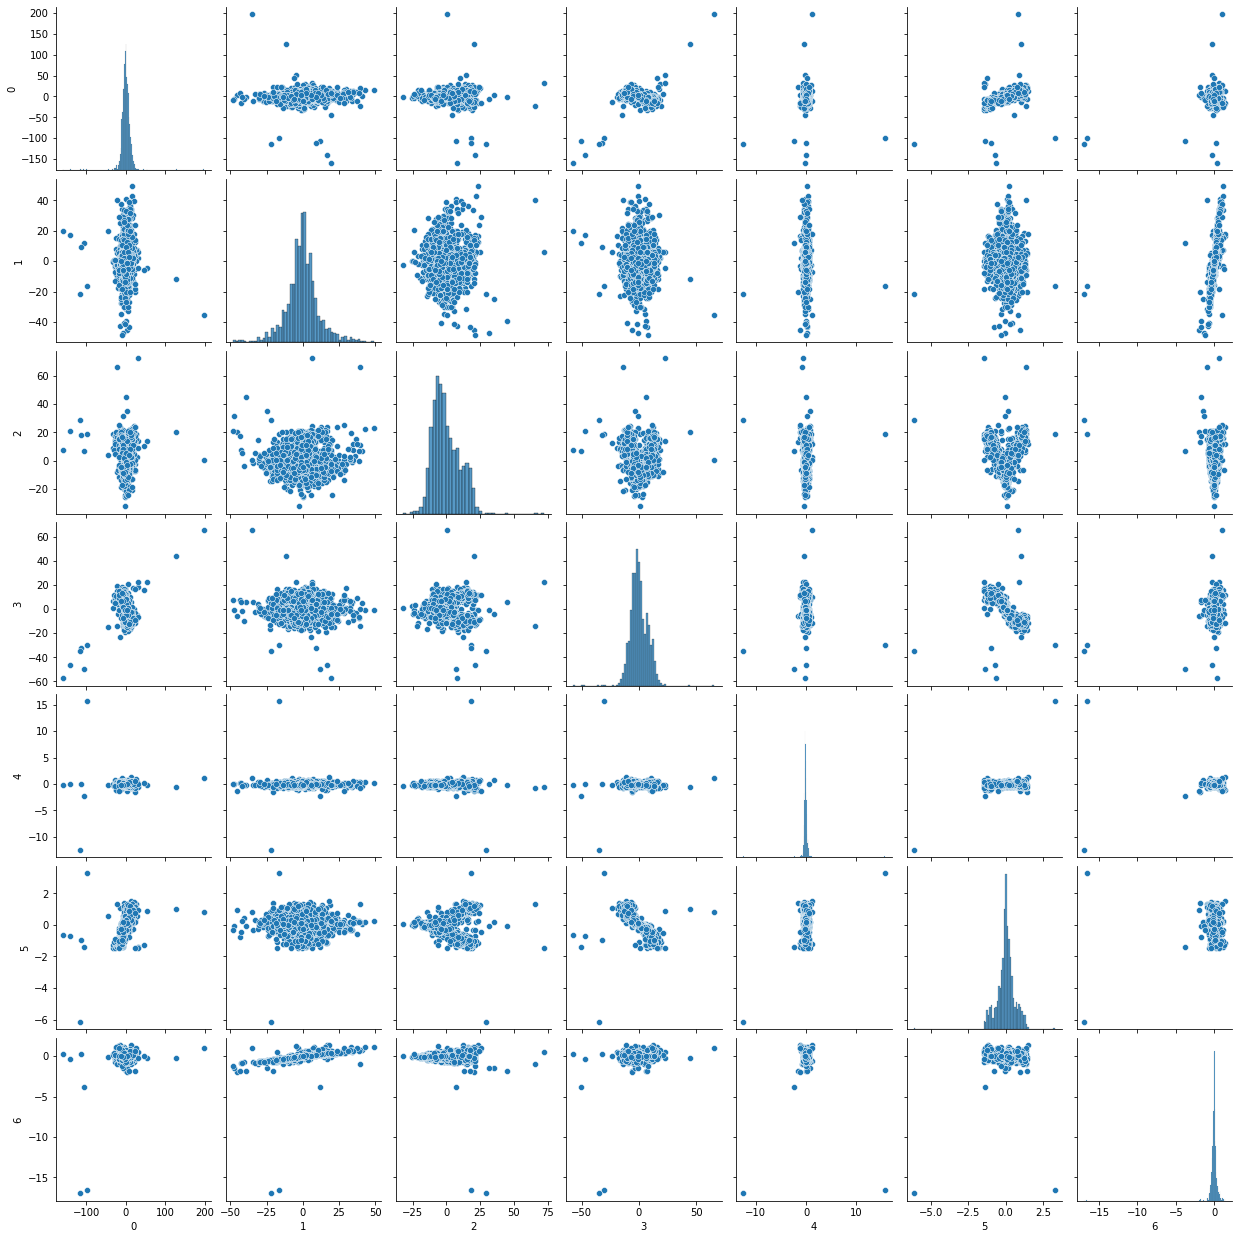

In [14]:
import seaborn as sns
sns.pairplot(pd.DataFrame(np.concatenate([Xy_train_c,yy_train.values],axis=1)))

In [15]:
Xrp = rollpitch_df.drop(['yaw','pitch','roll'],axis=1)
yrp = rollpitch_df[['pitch','yaw','roll']]
Xrp_train, Xrp_test, yrp_train, yrp_test = train_test_split(Xrp, yrp, test_size=0.20, random_state=42)
scaler = StandardScaler()
# Xrp_train = scaler.fit_transform(Xrp_train)
# Xrp_test = scaler.transform(Xrp_test)
pca = PCA(0.95)
Xrp_train_c = pca.fit_transform(scaler.fit_transform(Xrp_train))
Xrp_test_c = pca.transform(scaler.transform(Xrp_test))
Xrp_train_c.shape

(1482, 3)

like the previes but here we will see that linear model not better like above but may be used it may be like polynomial models or ensambling like random forest we will see the best in Model section

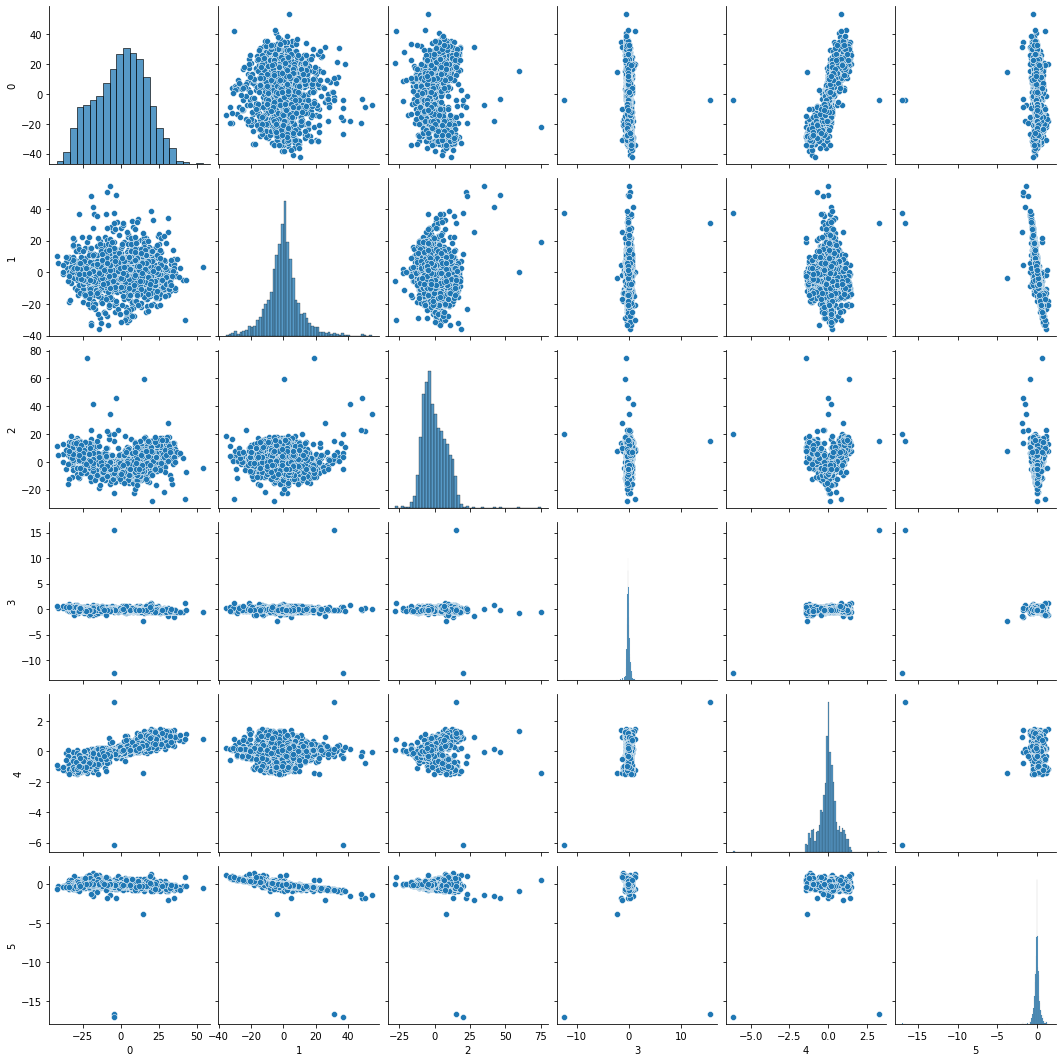

In [16]:
import seaborn as sns
sns.pairplot(pd.DataFrame(np.concatenate([Xrp_train_c,yrp_train.values],axis=1)))

# Models

In [30]:
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor,StackingRegressor,AdaBoostRegressor,BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer,StandardScaler,RobustScaler

after the nest trials i see that the error is very different in each one of the three labels so i decided to use individual model to each one

In [42]:
regre= MultiOutputRegressor(Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])).fit(X_train, y_train)
regre.score(X_test, y_test)

0.3983969235234386

In [40]:
regre= MultiOutputRegressor(RandomForestRegressor()).fit(X_train, y_train)
regre.score(X_test, y_test)

0.5979003593510147

In [82]:
regre_svr = MultiOutputRegressor(SVR(C=1.5,gamma=0.257,epsilon=0.0005)).fit(X_train, y_train)
print(regre_svr.score(X_test, y_test))
y_pred = regre_svr.predict(X_test)

0.7144324318077114


In [83]:
mean_squared_error(y_test,y_pred)

0.037758477872833936

In [84]:
mse_one = mean_squared_error(y_test['pitch'], y_pred[:,0])
mse_two = mean_squared_error(y_test['yaw'], y_pred[:,1])
mse_three = mean_squared_error(y_test['roll'], y_pred[:,2])
print(f'MAE for first regressor: {mse_one} - second regressor: {mse_two} - Third regressor: {mse_three}')
r2_one = r2_score(y_test['pitch'], y_pred[:,0])
r2_two = r2_score(y_test['yaw'], y_pred[:,1])
r2_three = r2_score(y_test['roll'], y_pred[:,2])
print(f'MAE for first regressor: {r2_one} - second regressor: {r2_two} - Third regressor: {r2_three}')

MAE for first regressor: 0.04898669366241594 - second regressor: 0.018693040681065944 - Third regressor: 0.04559569927501991
MAE for first regressor: 0.5523917169058961 - second regressor: 0.9304155070814683 - Third regressor: 0.66049007143577


In [85]:
import pickle
filename = 'Model.sav'
pickle.dump(regre_svr, open(filename, 'wb'))

In [35]:
regre= MultiOutputRegressor(HistGradientBoostingRegressor()).fit(X_train, y_train)
regre.score(X_test, y_test)

0.49663261541237924

In [119]:
regre_svr = MultiOutputRegressor(XGBRegressor()).fit(X_train, y_train)
print(regre_svr.score(X_test, y_test))
y_pred_xg = regre_svr.predict(X_test)

[07:28:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:28:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:28:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.6166392951144338


In [34]:
mse_one = mean_squared_error(y_test['pitch'], y_pred_xg[:,0])
mse_two = mean_squared_error(y_test['yaw'], y_pred_xg[:,1])
mse_three = mean_squared_error(y_test['roll'], y_pred_xg[:,2])
print(f'MAE for first regressor: {mse_one} - second regressor: {mse_two} - Third regressor: {mse_three}')
r2_one = r2_score(y_test['pitch'], y_pred_xg[:,0])
r2_two = r2_score(y_test['yaw'], y_pred_xg[:,1])
r2_three = r2_score(y_test['roll'], y_pred_xg[:,2])
print(f'MAE for first regressor: {r2_one} - second regressor: {r2_two} - Third regressor: {r2_three}')

MAE for first regressor: 0.050666986817171675 - second regressor: 0.01947452236571058 - Third regressor: 0.051800818188957425
MAE for first regressor: 0.5370382999294807 - second regressor: 0.9275064561849923 - Third regressor: 0.6142861637712228


## yaw models

first i start using Ridge with solver = 'sag' (as i don't need normal equation here) and and the model accuracy on test data was 0.87 
and after alot of chnages between alpha and max_itr and solver to try make the algorithm get more acc it still = 0.87

In [97]:
yaw_regre = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(solver='sag',alpha=0,max_iter=10000))])
yaw_regre.fit(Xy_train_c, yy_train['yaw'])
y_pred = yaw_regre.predict(Xy_test_c)
print('r2_score:',r2_score(yy_test['yaw'], y_pred))
print('training score:', yaw_regre.score(Xy_train_c, yy_train['yaw']))
print('MSE:',mean_squared_error(yy_test['yaw'], y_pred))

r2_score: 0.873811822079403
training score: 0.7910972548493072
MSE: 0.04050687706739076


so next i will try SVR first i will try to overfit the data so i used SVR(C=100,gamma=0.5, epsilon=0.0001) and get r2_score: 0.13 on testing and 0.999 on training and after changing in gamma and C values the overfiting reduces using this model SVR(C=50,gamma=0.001, epsilon=0.0001) with 0.91 on testset and 0.97 on training and i will still reduce C to have bigger margin and reduce overfitting with C=20 r2_score = 0.92
and my goal is to get less C value with most accuracy the last model in SVR is SVR(C=0.5,gamma=0.001, epsilon=0.005) with 0.92 acc on testing
and 0.93 using the whole data without PCA



In [95]:
yaw_regre = Pipeline([('scaler', StandardScaler()), ('svr', SVR(C=0.5,gamma=0.001, epsilon=0.005))])
yaw_regre.fit(Xy_train, yy_train['yaw'])
y_pred = yaw_regre.predict(Xy_test)
print('r2_score:',r2_score(yy_test['yaw'], y_pred))
print('training score:', yaw_regre.score(Xy_train, yy_train['yaw']))
print('MSE:',mean_squared_error(yy_test['yaw'], y_pred))

r2_score: 0.9319345371321959
training score: 0.8692146298232819
MSE: 0.021849268151380174


i will start with RandomForestRegressor and see what will happen if i try to overfit it and then change its hyperparameter:

 with max_depth=100,n_estimators=100: 0.92 on testing and 0.97 on training
so i work on reducing number of estimators and max depth to reduce overfitting

 max acc with RandomForestRegressor(random_state=42,max_depth=35,n_estimators=19) with 0.95 on testing but i get 0.94 with max_depth=15,n_estimators=10 witch is very good

In [94]:
yaw_regre =  Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor(random_state=42,max_depth=35,n_estimators=19))])
yaw_regre.fit(Xy_train, yy_train['yaw'])
y_pred = yaw_regre.predict(Xy_test)
print('r2_score:',r2_score(yy_test['yaw'], y_pred))
print('training score:', yaw_regre.score(Xy_train, yy_train['yaw']))
print('MSE:',mean_squared_error(yy_test['yaw'], y_pred))

r2_score:  0.9517095402053244
training score:  0.9537085960337404
MSE: 0.015501418204655903


In [89]:
import pickle
filename = 'yaw_model_95.sav'
pickle.dump(yaw_regre, open(filename, 'wb'))

## Pitch Model

first i will try Lasso with alpha=0.1 it gives r2_score=0.2 and after some trials used alpha =0.01 that gives r2_score = 0.46 and then change it to alpha = 0.005 with r2_score=0.47 and the alpha = 0.001 with r2_score = 0.48

In [108]:
pitch_regre = Pipeline([('scaler', StandardScaler()), ('svr', Lasso(alpha=0.001,selection='random'))])
pitch_regre.fit(X_train, y_train['pitch'])
y_pred = pitch_regre.predict(X_test)
print('r2_score:',r2_score(y_test['pitch'], y_pred))
print('training score:', pitch_regre.score(X_train, y_train['pitch']))
print('MSE:', mean_squared_error(y_test['pitch'], y_pred))

r2_score: 0.48946703194809227
training score: 0.17700303902306858
MSE: 0.055873233483628125


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.754e+00, tolerance: 5.181e-02
  model = cd_fast.enet_coordinate_descent(


Try Ridge with alpha = 0.1 r2_score=0.11, with alpha = 0.1 and solver ='sag' r2_score=0.49 then using saga solver with tol=1e-6 give r2_score 0.49

In [109]:
pitch_regre = Pipeline([('scaler', StandardScaler()), ('svr', Ridge(alpha=0.1,tol=1e-6,solver='saga'))])
pitch_regre.fit(X_train, y_train['pitch'])
y_pred = pitch_regre.predict(X_test)
print('r2_score:',r2_score(y_test['pitch'], y_pred))
print('training score:', pitch_regre.score(X_train, y_train['pitch']))
print('MSE:', mean_squared_error(y_test['pitch'], y_pred))

r2_score: 0.4905205893958112
training score: 0.16735689691543687
MSE: 0.05575793111346105


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Try SVR with SVR(C=1000,gamma=0.01, epsilon=0.01) to overfit the model so we get 0.99 on training and 0.075 on testing after some changes i reach to SVR(C=20,gamma=0.01, epsilon=0.001) with 0.89 on training and 0.27 on testing and again after some trails we get SVR(C=15,gamma=0.001, epsilon=0.001) that has higher performance on testing 0.47 but become poor on training

tried log transformation on the data to remove exponential but didn't affected

and after alot of trials end with SVR(C=3,epsilon=0.001,gamma=0.0001) with r2_score: 0.53 and then with SVR(C=1.5,gamma=0.257,epsilon=0.00005) i get r2_score=0.55 and MSE=0.04

In [110]:
pitch_regre = SVR(C=1.5,gamma=0.257,epsilon=0.00005)
pitch_regre.fit(X_train, y_train['pitch'])
y_pred = pitch_regre.predict(X_test)
print('r2_score:',r2_score(y_test['pitch'], y_pred))
print('training score:', pitch_regre.score(X_train, y_train['pitch']))
print('MSE:', mean_squared_error(y_test['pitch'], y_pred))

r2_score: 0.552473658762995
training score: 0.2716526385708037
MSE: 0.048977725864447395


In [111]:
import pickle
filename = 'pitch_model_55.sav'
pickle.dump(pitch_regre, open(filename, 'wb'))

Try using ensamble models and DecissionTree and these some of the best results i get after some trials 

In [114]:
pitch_regre =  Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor(random_state=42,max_depth=10,n_estimators=10))])
pitch_regre.fit(X_train, y_train['pitch'])
y_pred = pitch_regre.predict(X_test)
print('r2_score:',r2_score(y_test['pitch'], y_pred))
print('training score:', pitch_regre.score(X_train, y_train['pitch']))
print('MSE:', mean_squared_error(y_test['pitch'], y_pred))

r2_score: 0.43885836169817116
training score: 0.629883376790952
MSE: 0.061411896461573724


start with default parameters and get 0.49 r2 and then start with first parameter n_estimators and try to get the best value, start from 200 and try to reduce it and i found that 100 is the like the most bigger number in r2_score but less in training score = 0.97 and this is satisfied for me so let's try second parameter: here i will start with small value as the model already overfites the data and the resullt was also overfitting 0.98 on training and 0.5 on testing, so let's try reducing n_estimators to 50: result is 0.96 ontraining and 0.5 on testing then reduce to 25 result is 0.88 on training and 0.48 on testing

try alot of number to these two parameters but the model still overfits the data so let's try regularization alpha and lambda parametrs after trying alot ov different values it affects training acc but still not doing will on testing

In [153]:
pitch_regre =  Pipeline([('rf', XGBRegressor(n_estimators=40,max_depth=10,reg_lambda=10))])
pitch_regre.fit(X_train, y_train['pitch'])
y_pred = pitch_regre.predict(X_test)
print('r2_score:',r2_score(y_test['pitch'], y_pred))
print('training score:', pitch_regre.score(X_train, y_train['pitch']))
print('MSE:', mean_squared_error(y_test['pitch'], y_pred))
# max_depth=10,n_estimators=60,reg_alpha=7,reg_lambda=0.7

[07:52:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
r2_score: 0.49054152184167377
training score: 0.6163253137959652
MSE: 0.0557556402458614


In [158]:

pitch_regre =  Pipeline([('scaler', StandardScaler()), 
                         ('rf', DecisionTreeRegressor(random_state=42,max_depth=20,min_samples_leaf=50,max_leaf_nodes=50))])
pitch_regre.fit(X_train, y_train['pitch'])
y_pred = pitch_regre.predict(X_test)
print('r2_score:',r2_score(y_test['pitch'], y_pred))
print('training score:', pitch_regre.score(X_train, y_train['pitch']))
print('MSE:', mean_squared_error(y_test['pitch'], y_pred))

r2_score: 0.4345015606021525
training score: 0.18352483394396024
MSE: 0.06188870908703149


## roll Model

start with Ridge with default parameters and get 0.35 on testing and after trying alot of lpha values its performance still not good

In [162]:
roll_regre = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha=0.01,solver='sag'))])
roll_regre.fit(Xrp_train_c, yrp_train['roll'])
y_pred = roll_regre.predict(Xrp_test_c)
print('r2_score:',r2_score(yrp_test['roll'], y_pred))
print('training score:', roll_regre.score(Xrp_train_c, yrp_train['roll']))
print('MSE:', mean_squared_error(yrp_test['roll'], y_pred))

r2_score: 0.3556286582287346
training score: 0.24272921958765636
MSE: 0.10131966593122632


Try SVR with SVR(C=1000, epsilon=0.001) to overfit the model so we get 0.91 on training and 0.29 on testing after some changes i reach to SVR(C=20, epsilon=0.001) with 0.61 on training and 0.61 on testing and then add gamma parameter with 0.0001 and get 0.64 r2_score on testing. 

and then try to reduce C value and found that C=15 gives the same r2_score 

tried log transformation on the data to remove exponential but didn't affected

and after alot of trials end with SVR(C=6,epsilon=0.01) with r2_score: 0.64 

In [189]:
roll_regre = Pipeline([('scaler', StandardScaler()), ('svr', SVR(C=6,epsilon=0.01))])
roll_regre.fit(Xrp_train, yrp_train['roll'])
y_pred = roll_regre.predict(Xrp_test)
print('r2_score: ',r2_score(yrp_test['roll'], y_pred))
print('training score: ', roll_regre.score(Xrp_train, yrp_train['roll']))
print('test score: ', roll_regre.score(Xrp_test, yrp_test['roll']))

r2_score:  0.645298031216339
training score:  0.39688110190973047
test score:  0.645298031216339


In [169]:
import pickle
filename = 'roll_model_65.sav'
pickle.dump(roll_regre, open(filename, 'wb'))

In [166]:
roll_regre = Pipeline([('scaler', StandardScaler()), ('svr', SVR(C=2.5,epsilon=0.001))])
roll_regre.fit(Xrp_train_c, yrp_train['roll'])
y_pred = roll_regre.predict(Xrp_test_c)
print('r2_score: ',r2_score(yrp_test['roll'], y_pred))
print('training score: ', roll_regre.score(Xrp_train_c, yrp_train['roll']))
print('test score: ', roll_regre.score(Xrp_test_c, yrp_test['roll']))

r2_score:  0.622998220576415
training score:  0.34659732179750635
test score:  0.622998220576415
